## Visualize saliency maps
TGRS [Kurihana et al. 2021](https://ieeexplore.ieee.org/document/9497325)  Appendix.F **Figure.23**  
https://usmanr149.github.io/urmlblog/cnn/2020/05/01/Salincy-Maps.html

In [1]:
%matplotlib inline
import os
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt

print('tensorflow {}'.format(tf.__version__))
print("keras {}".format(keras.__version__))

tensorflow 2.6.0-dev20210605
keras 2.6.0


In [2]:
from tensorflow.python.keras.models import Model

In [3]:
import tensorflow.keras.backend as K

In [4]:
import cv2

In [5]:
from matplotlib.backends.backend_pdf import PdfPages

In [6]:
import matplotlib as mpl

In [37]:
import pickle

### Load model

In [7]:
def load_latest_model(model_dir, mtype):
    #TODO add restart model dir and restart argument?
    latest = 0, None
    # get trained wegiht 
    for m in os.listdir(model_dir):
        if ".h5" in m and mtype in m:
            epoch = int(m.split("-")[1].replace(".h5", ""))
            latest = max(latest, (epoch, m))

    epoch, model_file = latest

    if not os.listdir(model_dir):
        raise NameError("no directory. check model path again")

    print(" Load {} at {} epoch".format(mtype, epoch))
    model_def = model_dir+'/'+mtype+'.json'
    model_weight = model_dir+'/'+mtype+'-'+str(epoch)+'.h5'
    with open(model_def, "r") as f:
        model = tf.keras.models.model_from_json(f.read())
    model.load_weights(model_weight)
    return model

In [10]:
#model_datadir='/home/tkurihana/rotate_invariant/stepbystep/transform/output_model'
model_datadir='/home/tkurihana/Research/models'
expname='67011582'
model_dir=os.path.join(model_datadir, expname)

In [11]:
encoder = load_latest_model(model_dir, mtype='encoder')
decoder = load_latest_model(model_dir, mtype='decoder')

 Load encoder at 100 epoch
 Load decoder at 100 epoch


In [183]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoding_input (InputLayer)  [(None, 32, 32, 6)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        1760      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0   

### Load top 20 patches

In [12]:
spatches = np.load('top20-selectedpatches.npy')

In [13]:
rspatches = tf.image.resize(spatches, (32,32))

In [14]:
img = tf.keras.backend.eval(rspatches)

In [15]:
img = encoder.predict(rspatches)

In [16]:
layer_names = [layer.name for layer in decoder.layers]
for layer_name in layer_names[1:]:
    if  'conv' in layer_name:
        print(layer_name)

conv2d_transpose
conv2d_15
conv2d_16
conv2d_transpose_1
conv2d_17
conv2d_18
conv2d_transpose_2
conv2d_19
conv2d_20
conv2d_transpose_3
conv2d_21
conv2d_22
conv2d_23


### Compute silency map

In [17]:
model = encoder
LAYER_NAME = 'conv2d_14'

- Method 1

In [50]:
#https://github.com/tensorflow/tensorflow/issues/37680
# Create a graph that outputs target convolution and output
grad_model = tf.keras.models.Model(inputs = [model.input], 
                                   outputs=[model.output, model.get_layer(LAYER_NAME).output])

print(model.get_layer(LAYER_NAME).output)
# Get the score for target class

# Get the score for target class
with tf.GradientTape() as tape:
    predictions, conv_outputs = grad_model(img)
    loss = predictions[:, 1]
print('Prediction shape:', predictions.get_shape())
# Extract filters and gradients
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 128), dtype=tf.float32, name=None), name='conv2d_18/BiasAdd:0', description="created by layer 'conv2d_18'")
Prediction shape: (240, 32, 32, 6)


- Method 2

In [136]:
# https://stackoverflow.com/questions/55924331/how-to-apply-guided-backprop-in-tensorflow-2-0
@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

gb_model = Model(
    inputs = [model.inputs],
    outputs = [model.get_layer(LAYER_NAME).output]
)
layer_dict = [layer for layer in gb_model.layers[1:] ]
for layer in layer_dict:
    if 're_lu' in layer.name:
            layer = guidedRelu


with tf.GradientTape() as tape:
  inputs = tf.cast(rspatches, tf.float32)
  tape.watch(inputs)
  outputs = gb_model(inputs)

grads = tape.gradient(outputs,inputs)#[0]

In [137]:
grads.shape

TensorShape([240, 32, 32, 6])

- Method 3  
https://www.kaggle.com/nguyenhoa/dog-cat-classifier-gradcam-with-tensorflow-2-0

In [15]:
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

# Reference: https://github.com/eclique/keras-gradcam with adaption to tensorflow 2.0  
class GuidedBackprop:
    def __init__(self,model, layerName=None):
        self.model = model
        self.layerName = layerName
        self.gbModel = self.build_guided_model()
        
        if self.layerName == None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply Guided Backpropagation")

    def build_guided_model(self):
        gbModel = Model(
            inputs = [self.model.inputs],
            outputs = [self.model.get_layer(self.layerName).output]
        )
        layer_dict = [layer for layer in gbModel.layers[1:] if hasattr(layer,"activation")]
        for layer in layer_dict:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guidedRelu
        
        return gbModel
    
    def guided_backprop(self, images, upsample_size):
        """Guided Backpropagation method for visualizing input saliency."""
        with tf.GradientTape() as tape:
            inputs = tf.cast(images, tf.float32)
            tape.watch(inputs)
            outputs = self.gbModel(inputs)

        grads = tape.gradient(outputs, inputs)[0]
    
        saliency = cv2.resize(np.asarray(grads), upsample_size)

        return saliency

In [179]:
guidedBP = GuidedBackprop(model=decoder,layerName="conv2d_20")

In [180]:
#upsample_size = (rspatches.shape[1],rspatches.shape[2])
#x = np.expand_dims(rspatches[0], axis=0)
upsample_size = (rspatches.shape[1],rspatches.shape[2])
x = np.expand_dims(encoder.predict(rspatches)[0], axis=0)
gb = guidedBP.guided_backprop(x, upsample_size)

In [181]:
gb.shape

(32, 32, 512)

In [190]:
gb_dict = {}
for layer_name in ["conv2d","conv2d_3","conv2d_6","conv2d_9","conv2d_12","conv2d_14"]:
    guidedBP = GuidedBackprop(model=encoder,layerName=layer_name)
    upsample_size = (rspatches.shape[1],rspatches.shape[2])
    #x = np.expand_dims(rspatches, axis=0)
    x = rspatches
    gb = guidedBP.guided_backprop(x, upsample_size)
    gb_dict[layer_name] = gb

In [166]:
np.argmax(np.mean(gb,axis=(0,1)))

199

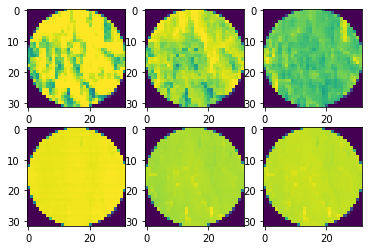

In [149]:
plt.figure()
for i in range(6):
    ii = i+1
    ax = plt.subplot(2,3,ii)
    ax.imshow(rspatches[0,:,:,i])

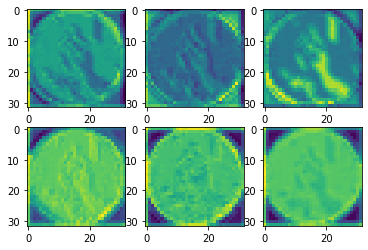

In [153]:
plt.figure()
for i in range(6):
    ii = i+1
    ax = plt.subplot(2,3,ii)
    ax.imshow(gb[:,:,i])

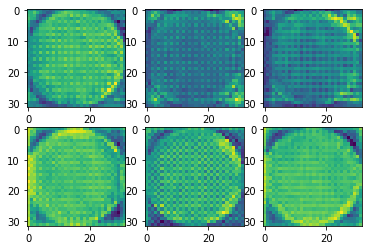

In [161]:
plt.figure()
for i in range(6):
    ii = i+1
    ax = plt.subplot(2,3,ii)
    ax.imshow(gb[:,:,i])

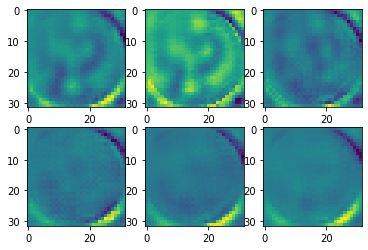

In [148]:
plt.figure()
for i in range(6):
    ii = i+1
    ax = plt.subplot(2,3,ii)
    ax.imshow(gb[:,:,i])

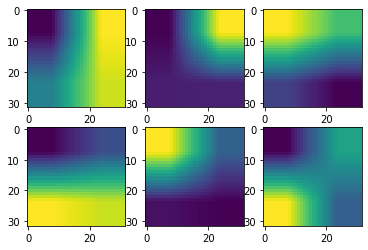

In [182]:
## conv2d_20
plt.figure()
for i in range(6):
    ii = i+1
    ax = plt.subplot(2,3,ii)
    ax.imshow(gb[:,:,i])

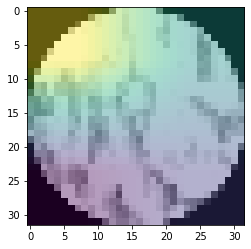

In [178]:
plt.figure()
plt.imshow(rspatches[0,:,:,0], cmap='gist_gray')
plt.imshow(gb[:,:,np.argmax(np.mean(gb,axis=(0,1)))],alpha=.4)
plt.show()

- Method 5

In [29]:
a = tf.keras.layers.LeakyReLU.

AttributeError: type object 'Conv2D' has no attribute 'activations'

In [18]:
def run_gg(rspatches,encoder,layer_name=None):
    # https://stackoverflow.com/questions/55924331/how-to-apply-guided-backprop-in-tensorflow-2-0
    @tf.custom_gradient
    def guidedRelu(x):
        def grad(dy):
            return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
        return tf.nn.relu(x), grad

    gb2_model = Model(
        inputs = [encoder.input],
        outputs = [encoder.get_layer(layer_name).output]
    )
    layer_dict = [layer for layer in gb2_model.layers[1:] ]
    for idx,layer in enumerate(layer_dict):
        if 'leaky_re_lu' in layer.name:
            #print(layer)
            try:
                print('before',gb2_model.layers[idx+1].layer)
                gb2_model.layers[idx+1].layer = guidedRelu
                #layer = guidedRelu
                #layer.activation = guidedRelu
                print('after',gb2_model.layers[idx+1].layer)
                #layer = guidedRelu
            except:
                pass
    print(gb2_model.summary())
    with tf.GradientTape() as tape:
        inputs = tf.cast(rspatches, tf.float32)
        tape.watch(inputs)
        outputs = gb2_model(inputs)

    grads = tape.gradient(outputs,inputs)
   
    return grads
    # Apply guided backpropagation
    #gate_f = tf.cast(outputs > 0, 'float32')
    #gate_r = tf.cast(grads > 0, 'float32')
    #print(outputs.shape, grads.shape)
    #c_outputs = tf.math.argmax(tf.math.mean(guided_grads,axis=(0,1,2)),axis=1)
    #guided_grads = tf.cast(outputs > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads
    
    #cgrads = tf.clip_by_norm(grads, 1.0)
    #cguided_grads = tf.math.argmax(tf.math.mean(guided_grads,axis=(0,1,2)),axis=1)
    #return cguided_grads

In [19]:
grads_dict = {}
# ["conv2d_1","conv2d_3","conv2d_6","conv2d_9","conv2d_12","conv2d_14"]:
# ["leaky_re_lu","leaky_re_lu_3","leaky_re_lu_6",
 #                  "leaky_re_lu_9","leaky_re_lu_12","leaky_re_lu_14"]
#
for layer_name in ["leaky_re_lu","leaky_re_lu_3","leaky_re_lu_6",
                   "leaky_re_lu_9","leaky_re_lu_12","leaky_re_lu_14"]:
    grads_dict[layer_name] =  run_gg(rspatches,encoder,layer_name)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoding_input (InputLayer)  [(None, 32, 32, 6)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        1760      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
Total params: 1,760
Trainable params: 1,760
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoding_input (InputLayer)  [(None, 32, 32, 6)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        1760      
_____________________________________

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoding_input (InputLayer)  [(None, 32, 32, 6)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        1760      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0   

#### Save grads_dict

In [38]:
with open("./saliency-grads_dict.pkl", 'wb') as f:
    pickle.dump(grads_dict, f)

### Visualization

In [20]:
def layer_plot(grads,nclusters = 12,ntops = 20,fsize=30,mycmap = 'twilight_shifted'):
    grads_np = tf.keras.backend.eval(grads)
    
    fig,ax = plt.subplots(2,12,figsize=(24,4))
    for i in range(nclusters):
        start = i*ntops
        cgrads = grads_np[start:start+ntops]
        for j in range(2):
            idx = np.argmax(np.mean(cgrads[j],axis=(0,1)) )
            vmax = np.mean(cgrads[j,:,:,idx]) + 2*np.std(cgrads[j,:,:,idx])
            vmin = np.mean(cgrads[j,:,:,idx]) - 2*np.std(cgrads[j,:,:,idx])  
            ax[j,i].imshow(cgrads[j,:,:,idx],cmap=mycmap,vmin=vmin,vmax=vmax) #
            ax[j,i].xaxis.set_visible(False)
            ax[j,i].yaxis.set_visible(False)
            if j == 0:
                ax[0,i].set_title(f'{i+1}', fontsize=fsize)
    plt.show()
    plt.close()

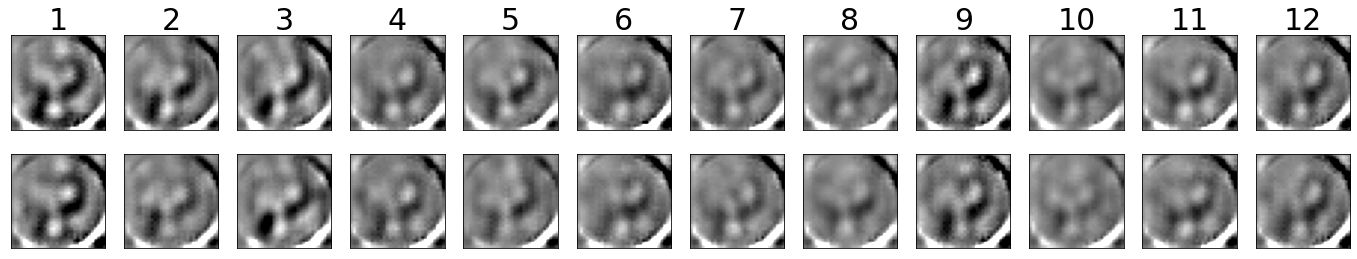

In [99]:
layer_plot(grads,nclusters = 12,ntops = 20,fsize=30,mycmap = 'gist_gray')

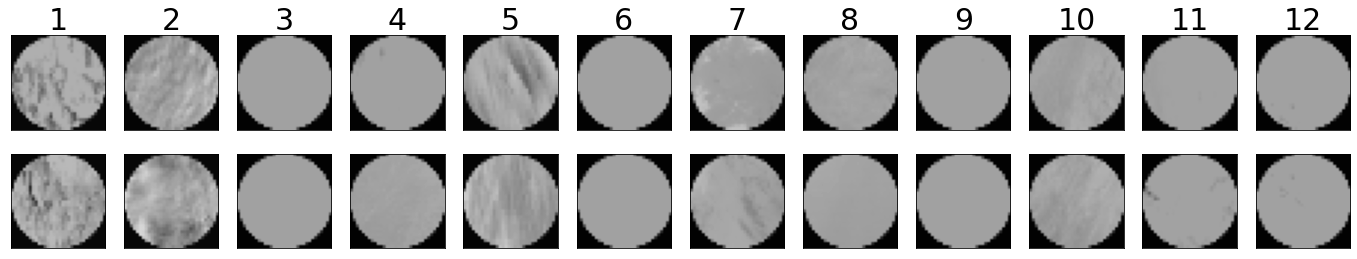

In [228]:
layer_plot(rspatches,nclusters = 12,ntops = 20,fsize=30,mycmap = 'gist_gray')

leaky_re_lu


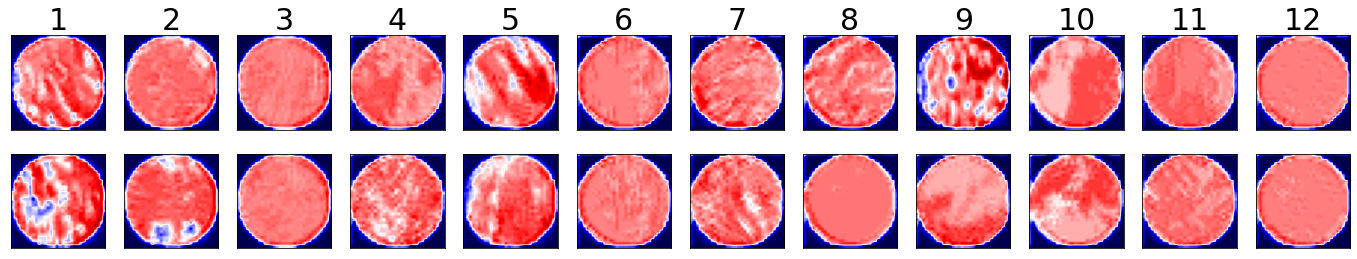

leaky_re_lu_3


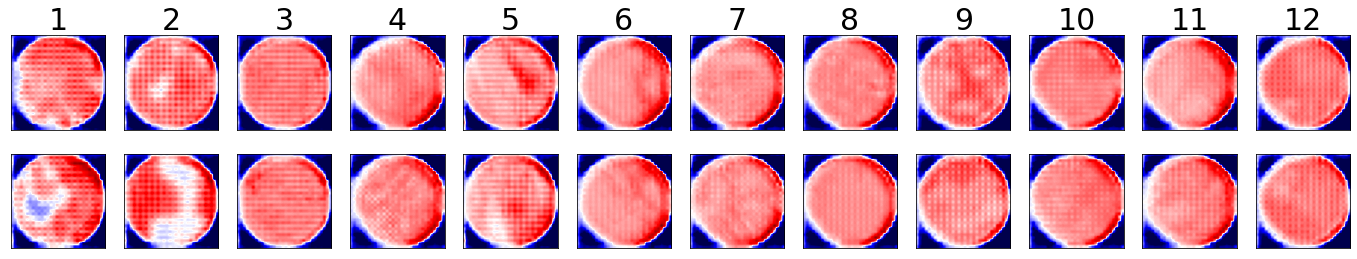

leaky_re_lu_6


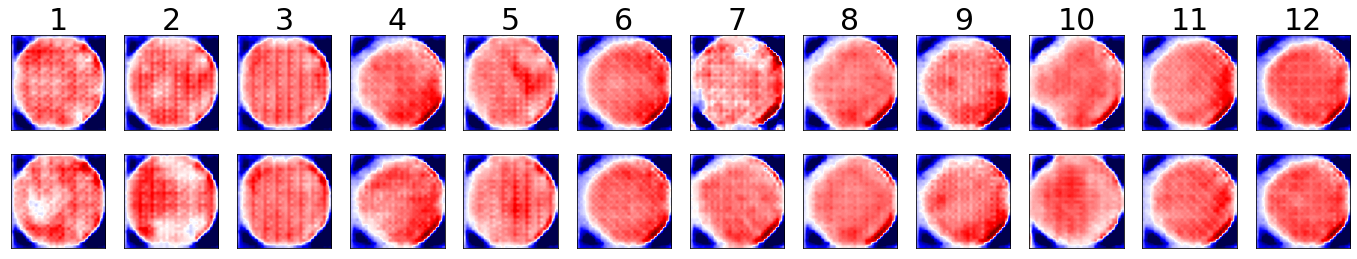

leaky_re_lu_9


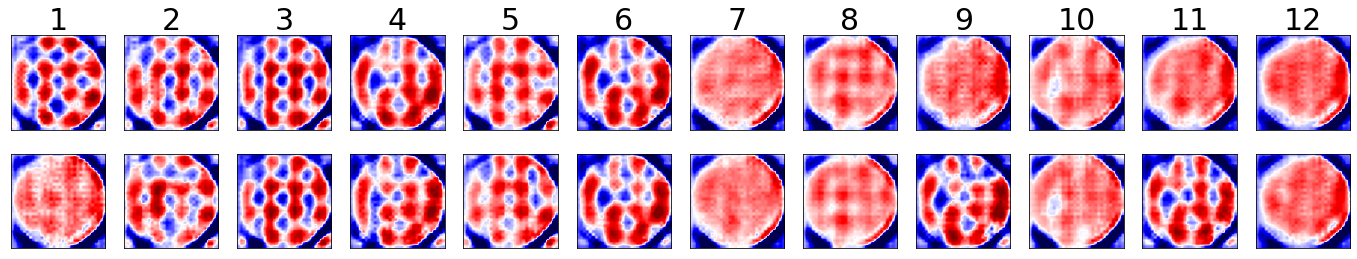

leaky_re_lu_12


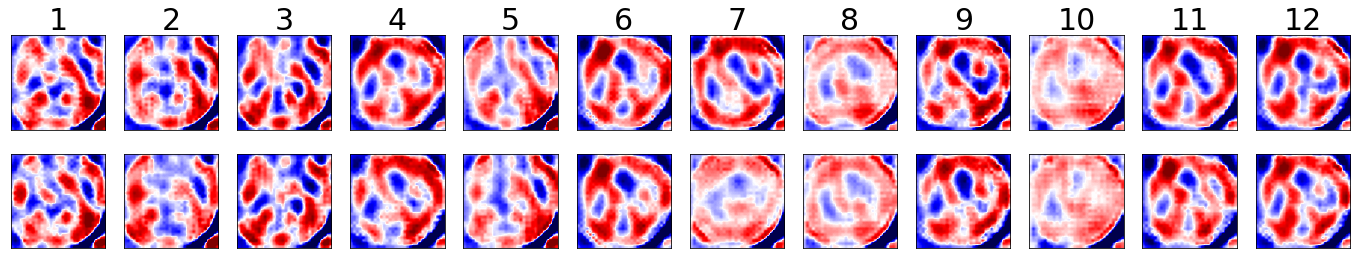

leaky_re_lu_14


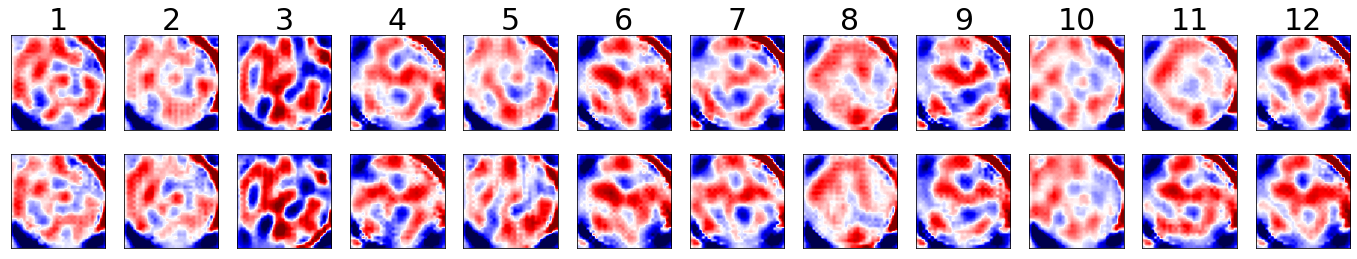

In [227]:
for key,_g in grads_dict.items():
    print(key)
    layer_plot(_g,nclusters = 12,ntops = 20,fsize=30,mycmap = 'seismic')

In [325]:
for key,_g in grads_dict.items():
    print(np.amax(_g), np.amin(_g))

9.372521 -9.428249
32.46212 -64.12752
50.63457 -118.41479
57.1579 -118.09728
61.286617 -99.846565
110.35804 -80.10376


In [217]:
for key,_g in grads_dict.items():
    print(np.amax(_g), np.amin(_g))

0.0023767392 -0.0023908708
0.00223758 -0.0044202427
0.0026361614 -0.006164968
0.0033451598 -0.0069116303
0.0055468986 -0.009036863
0.013247637 -0.009615842


### Load images for paper

In [29]:
simages = np.load('top20-selectedBand1.npy')

In [30]:
rsimages = np.concatenate([np.expand_dims(np.asarray(cv2.resize(i, (32,32) )),axis=0)
            for i in simages],axis=0)

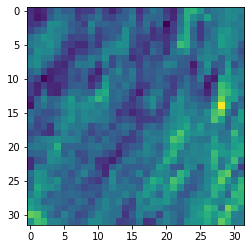

In [31]:
plt.imshow(rsimages[20])

###  Visualize for paper

In [21]:
import cv2
def get_masks(rpatch_size, channels):

    mask = np.zeros((rpatch_size, rpatch_size), dtype=np.float64)
    cv2.circle(mask, center=(rpatch_size // 2, rpatch_size // 2),
                radius=rpatch_size//2, color=1, thickness=-1)
    mask = np.expand_dims(mask, axis=-1)
    #  multiple dimension
    mask_list = [ mask for i in range(channels)]
    masks = np.concatenate(mask_list, axis=-1)
    return masks

In [22]:
def layer_plot_paper(images,rimages, grads_dict,nclusters = 12,ntops = 20,fsize=30,label_fsize=16,
               mycmap = 'twilight_shifted', alpha=2,ncols=None,nrows=12,layer_names=[]):
    
    fig,ax = plt.subplots(nrows,ncols,figsize=(alpha*ncols,alpha*nrows) ,dpi=100) # (24,4)
    
    # original 128 x 128
    for i in range(nclusters):
        ax[i,0].imshow(images[i*ntops],cmap='gist_gray')
        ax[i,0].xaxis.set_visible(False)
        ax[i,0].axes.yaxis.set_ticks([])
        #ax[i,0].yaxis.set_visible(False)
        ax[i,0].set_ylabel(f'{i+1}    ', fontsize=fsize,rotation=0)
    
    # rescale and masked - NaN Mask
    width = height = patch_size = 32
    nan_mask = get_masks(patch_size, 1).reshape(width,height)
    nan_idx = np.where(nan_mask == 0) 
    nan_mask[nan_idx] = 0 #np.nan
    for i in range(nclusters):
        ax[i,1].imshow(rimages[i*ntops]*nan_mask,cmap='gist_gray')
        ax[i,1].xaxis.set_visible(False)
        ax[i,1].yaxis.set_visible(False)
    
    def zscore(data):
        return (data - np.nanmean(data)) / np.nanstd(data)
    for _j, (key, grads) in enumerate(grads_dict.items()):
        j = _j +2
        #_grads = tf.cast(grads >= 0,'float32' )
        grads_np = tf.keras.backend.eval(grads)
        for i in range(nclusters):
            start = i*ntops
            cgrads = grads_np[start:start+ntops]
            zdx = np.where(cgrads <0)
            cgrads[zdx] = -0.0001
            idx = np.argmax(np.mean(cgrads[0],axis=(0,1)) )
            vmax = np.nanmax(cgrads[j,:,:,idx])#np.mean(cgrads[j,:,:,idx]) + 2*np.std(cgrads[j,:,:,idx])
            vmin=0
            cmap = mpl.cm.rainbow
            norm = mpl.colors.Normalize(vmin=0,vmax=vmax)
            cmap.set_under('slategray')
            #vmin = np.mean(cgrads[j,:,:,idx]) - 2*np.std(cgrads[j,:,:,idx])  
            #z_cgrads = zscore(cgrads[j,:,:,idx])
            #vmax =  2*np.std(z_cgrads)
            #vmin =  -2*np.std(z_cgrads)
            #ax[i,j].imshow(z_cgrads,cmap=mycmap,vmin=vmin,vmax=vmax)
            ax[i,j].imshow(cgrads[j,:,:,idx],cmap=cmap,norm=norm) #vmin=vmin,vmax=vmax
            ax[i,j].xaxis.set_visible(False)
            ax[i,j].yaxis.set_visible(False)
            #if i == 0:
            #    ax[0,i].set_title(f'{i+1}', fontsize=fsize)
    
    # title
    titles = ['Original','Input']+ layer_names
    for i in range(ncols):
        ax[0,i].set_title(titles[i],fontsize=label_fsize)
    
    plt.subplots_adjust(hspace = .000,wspace = -.01)
    os.makedirs('./figs', exist_ok=True)
    pdf = PdfPages(os.path.join('./figs', 'GuidedBackpropagation-2008Jan1st-nc12.pdf'))
    plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
    plt.show()
    pdf.close()
    pdf = None
    #fig.tight_layout()
    #plt.show()
    #plt.close()

In [23]:
def layer_plot_paper2(images,rimages, grads_dict,nclusters = 12,ntops = 20,fsize=30,label_fsize=16,
               mycmap = 'twilight_shifted', alpha=2,ncols=None,nrows=12,layer_names=[]):
    
    fig,ax = plt.subplots(nrows,ncols,figsize=(alpha*ncols,alpha*nrows) ,dpi=100) # (24,4)
    
    # original 128 x 128
    for i in range(nclusters):
        ax[i,0].imshow(images[i*ntops],cmap='gist_gray')
        ax[i,0].xaxis.set_visible(False)
        ax[i,0].axes.yaxis.set_ticks([])
        #ax[i,0].yaxis.set_visible(False)
        ax[i,0].set_ylabel(f'{i+1}    ', fontsize=fsize,rotation=0)
    
    # rescale and masked - NaN Mask
    width = height = patch_size = 32
    nan_mask = get_masks(patch_size, 1).reshape(width,height)
    nan_idx = np.where(nan_mask == 0) 
    nan_mask[nan_idx] = 0 #np.nan
    for i in range(nclusters):
        ax[i,1].imshow(rimages[i*ntops]*nan_mask,cmap='gist_gray')
        ax[i,1].xaxis.set_visible(False)
        ax[i,1].yaxis.set_visible(False)
    
    def zscore(data):
        return (data - np.nanmean(data)) / np.nanstd(data)
    for _j, (key, grads) in enumerate(grads_dict.items()):
        j = _j +2
        #_grads = tf.cast(grads >= 0,'float32' )
        #grads_np = tf.keras.backend.eval(grads)
        grads_np = np.flip(deprocess_image(np.array(grads)),-1)
        for i in range(nclusters):
            start = i*ntops
            cgrads = grads_np[start:start+ntops]
            idx = np.argmax(np.mean(cgrads[0],axis=(0,1)) )
            #idx = np.argmax(np.std(cgrads[0],axis=(0,1)) )
            #idx = 0
            vmax = np.nanmax(cgrads[j,:,:,idx])#np.mean(cgrads[j,:,:,idx]) + 2*np.std(cgrads[j,:,:,idx])
            vmin=0
            cmap = mpl.cm.gray
            norm = mpl.colors.Normalize(vmin=1.0e-10,vmax=vmax)
            cmap.set_under('black')
            #ax[i,j].imshow(cgrads[j,:,:],cmap=cmap,norm=norm)
            ax[i,j].imshow(cgrads[j,:,:,idx],cmap=cmap,norm=norm) #vmin=vmin,vmax=vmax
            ax[i,j].xaxis.set_visible(False)
            ax[i,j].yaxis.set_visible(False)
            #if i == 0:
            #    ax[0,i].set_title(f'{i+1}', fontsize=fsize)
    
    # title
    titles = ['Original','Input']+ layer_names
    for i in range(ncols):
        ax[0,i].set_title(titles[i],fontsize=label_fsize)
    
    plt.subplots_adjust(hspace = .000,wspace = -.01)
    os.makedirs('./figs', exist_ok=True)
    pdf = PdfPages(os.path.join('./figs', 'GuidedBackpropagation-2008Jan1st-nc12.pdf'))
    plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
    plt.show()
    pdf.close()
    pdf = None
    #fig.tight_layout()
    #plt.show()
    #plt.close()

In [24]:
def layer_plot_paper3(images,rimages, grads_dict,nclusters = 12,ntops = 20,fsize=30,label_fsize=16,
               mycmap = 'twilight_shifted', alpha=2,ncols=None,nrows=12,layer_names=[],ncluster_orders=[]):
    
    fig,ax = plt.subplots(nrows,ncols,figsize=(alpha*ncols,alpha*nrows) ,dpi=100) # (24,4)
    
    # original 128 x 128
    for i in range(nclusters):
        ii = ncluster_orders[i]
        ax[0,i].imshow(images[ii*ntops],cmap='gist_gray')
        ax[0,i].xaxis.set_visible(False)
        ax[0,i].axes.yaxis.set_ticks([])
        #ax[i,0].yaxis.set_visible(False)
        ax[0,i].set_title(f'{ii+1}', fontsize=label_fsize,rotation=0)
    
    # rescale and masked - NaN Mask
    width = height = patch_size = 32
    nan_mask = get_masks(patch_size, 1).reshape(width,height)
    nan_idx = np.where(nan_mask == 0) 
    nan_mask[nan_idx] = 0 #np.nan
    for i in  ncluster_orders:
        ii = ncluster_orders[i]
        ax[1,i].imshow(rimages[ii*ntops]*nan_mask,cmap='gist_gray')
        ax[1,i].xaxis.set_visible(False)
        ax[1,i].yaxis.set_visible(False)
    
    def zscore(data):
        return (data - np.nanmean(data)) / np.nanstd(data)
    for _j, (key, grads) in enumerate(grads_dict.items()):
        j = _j +2
        #_grads = tf.cast(grads >= 0,'float32' )
        #grads_np = tf.keras.backend.eval(grads)
        grads_np = np.flip(deprocess_image(np.array(grads)),-1)
        #for i in ncluster_orders:
        for i in range(nclusters):
            #print(i)
            ii = ncluster_orders[i]
            start = ii*ntops
            cgrads = grads_np[start:start+ntops]
            idx = np.argmax(np.mean(cgrads[0],axis=(0,1)) )
            #idx = np.argmax(np.std(cgrads[0],axis=(0,1)) )
            #idx = 0
            vmax = np.nanmax(cgrads[j,:,:,idx])#np.mean(cgrads[j,:,:,idx]) + 2*np.std(cgrads[j,:,:,idx])
            vmin=0
            cmap = mpl.cm.gray
            norm = mpl.colors.Normalize(vmin=1.0e-10,vmax=vmax)
            cmap.set_under('black')
            #ax[i,j].imshow(cgrads[j,:,:],cmap=cmap,norm=norm)
            ax[j,i].imshow(cgrads[j,:,:,idx],cmap=cmap,norm=norm) #vmin=vmin,vmax=vmax
            ax[j,i].xaxis.set_visible(False)
            ax[j,i].yaxis.set_visible(False)
            #if i == 0:
            #    ax[0,i].set_title(f'{i+1}', fontsize=fsize)
    
    # title
    titles = ['Original','Input']+ layer_names
    for i in range(len(titles)):
        ax[i,0].yaxis.set_visible(True)
        ax[i,0].axes.yaxis.set_ticks([])
        ax[i,0].set_ylabel(f'{titles[i]}               ',fontsize=fsize, rotation=0)
    
    plt.subplots_adjust(hspace = .000,wspace = -.01)
    os.makedirs('./figs', exist_ok=True)
    pdf = PdfPages(os.path.join('./figs', 'rGuidedBackpropagation-2008Jan1st-nc12.pdf'))
    plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
    plt.show()
    pdf.close()
    pdf = None
    #fig.tight_layout()
    #plt.show()
    #plt.close()

run plot

In [25]:
rspatches_np = tf.keras.backend.eval(rspatches)

In [26]:
#layer_names=["conv2d","conv2d_3","conv2d_6","conv2d_9","conv2d_12","conv2d_14"]
layer_names=["Conv","Block1","Block2","Block3","Block4","Block5"]

/home/tkurihana/.conda/envs/tf2-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))


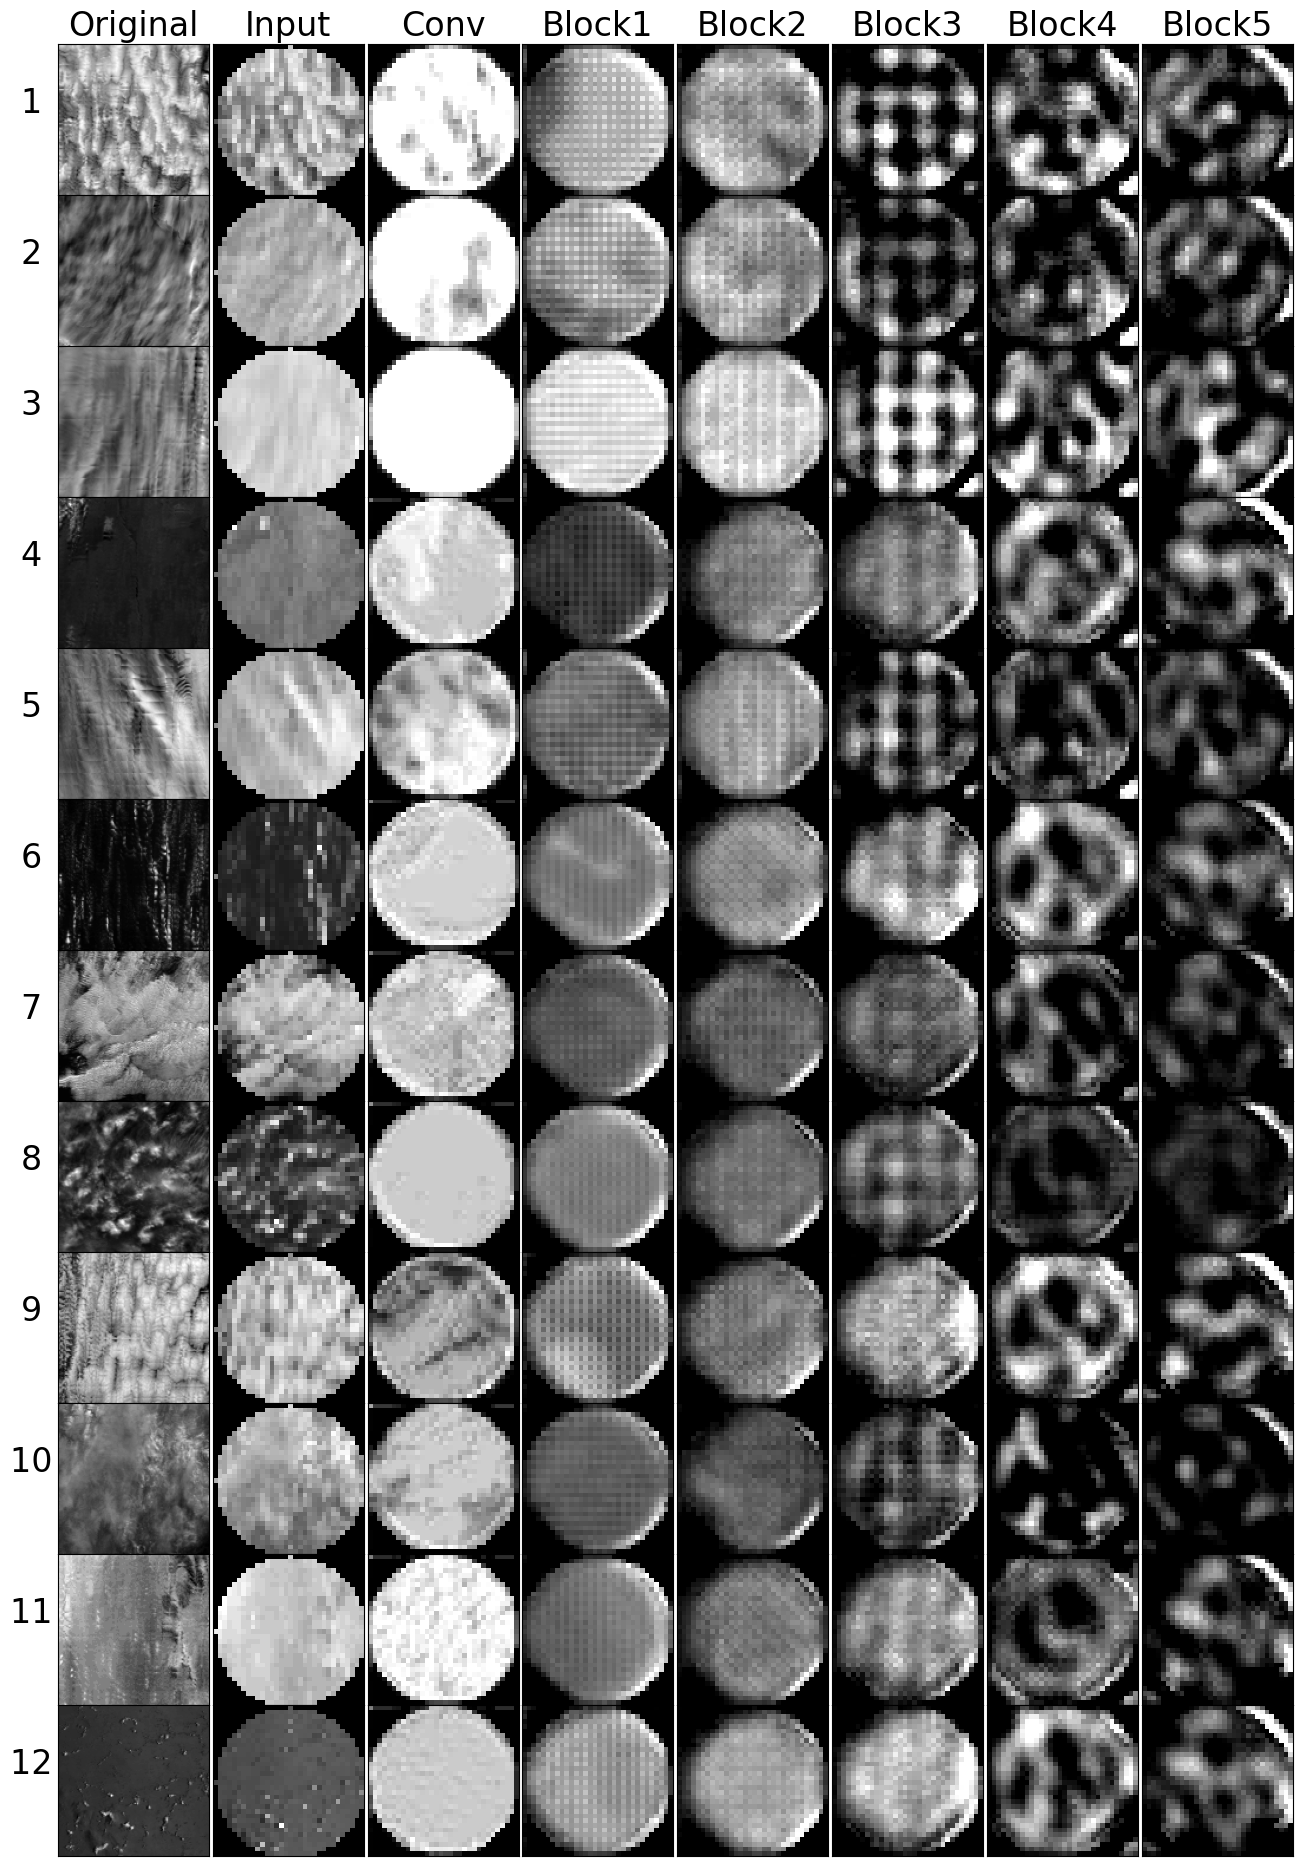

In [96]:
layer_plot_paper2(simages,rsimages, grads_dict,nclusters = 12,ntops = 20,fsize=24,label_fsize=24,
                 alpha=2,ncols=2+len(grads_dict),nrows=12,mycmap = 'binary_r',
                 layer_names=layer_names)

<ipython-input-24-3282ad56032e>:46: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_under('black')


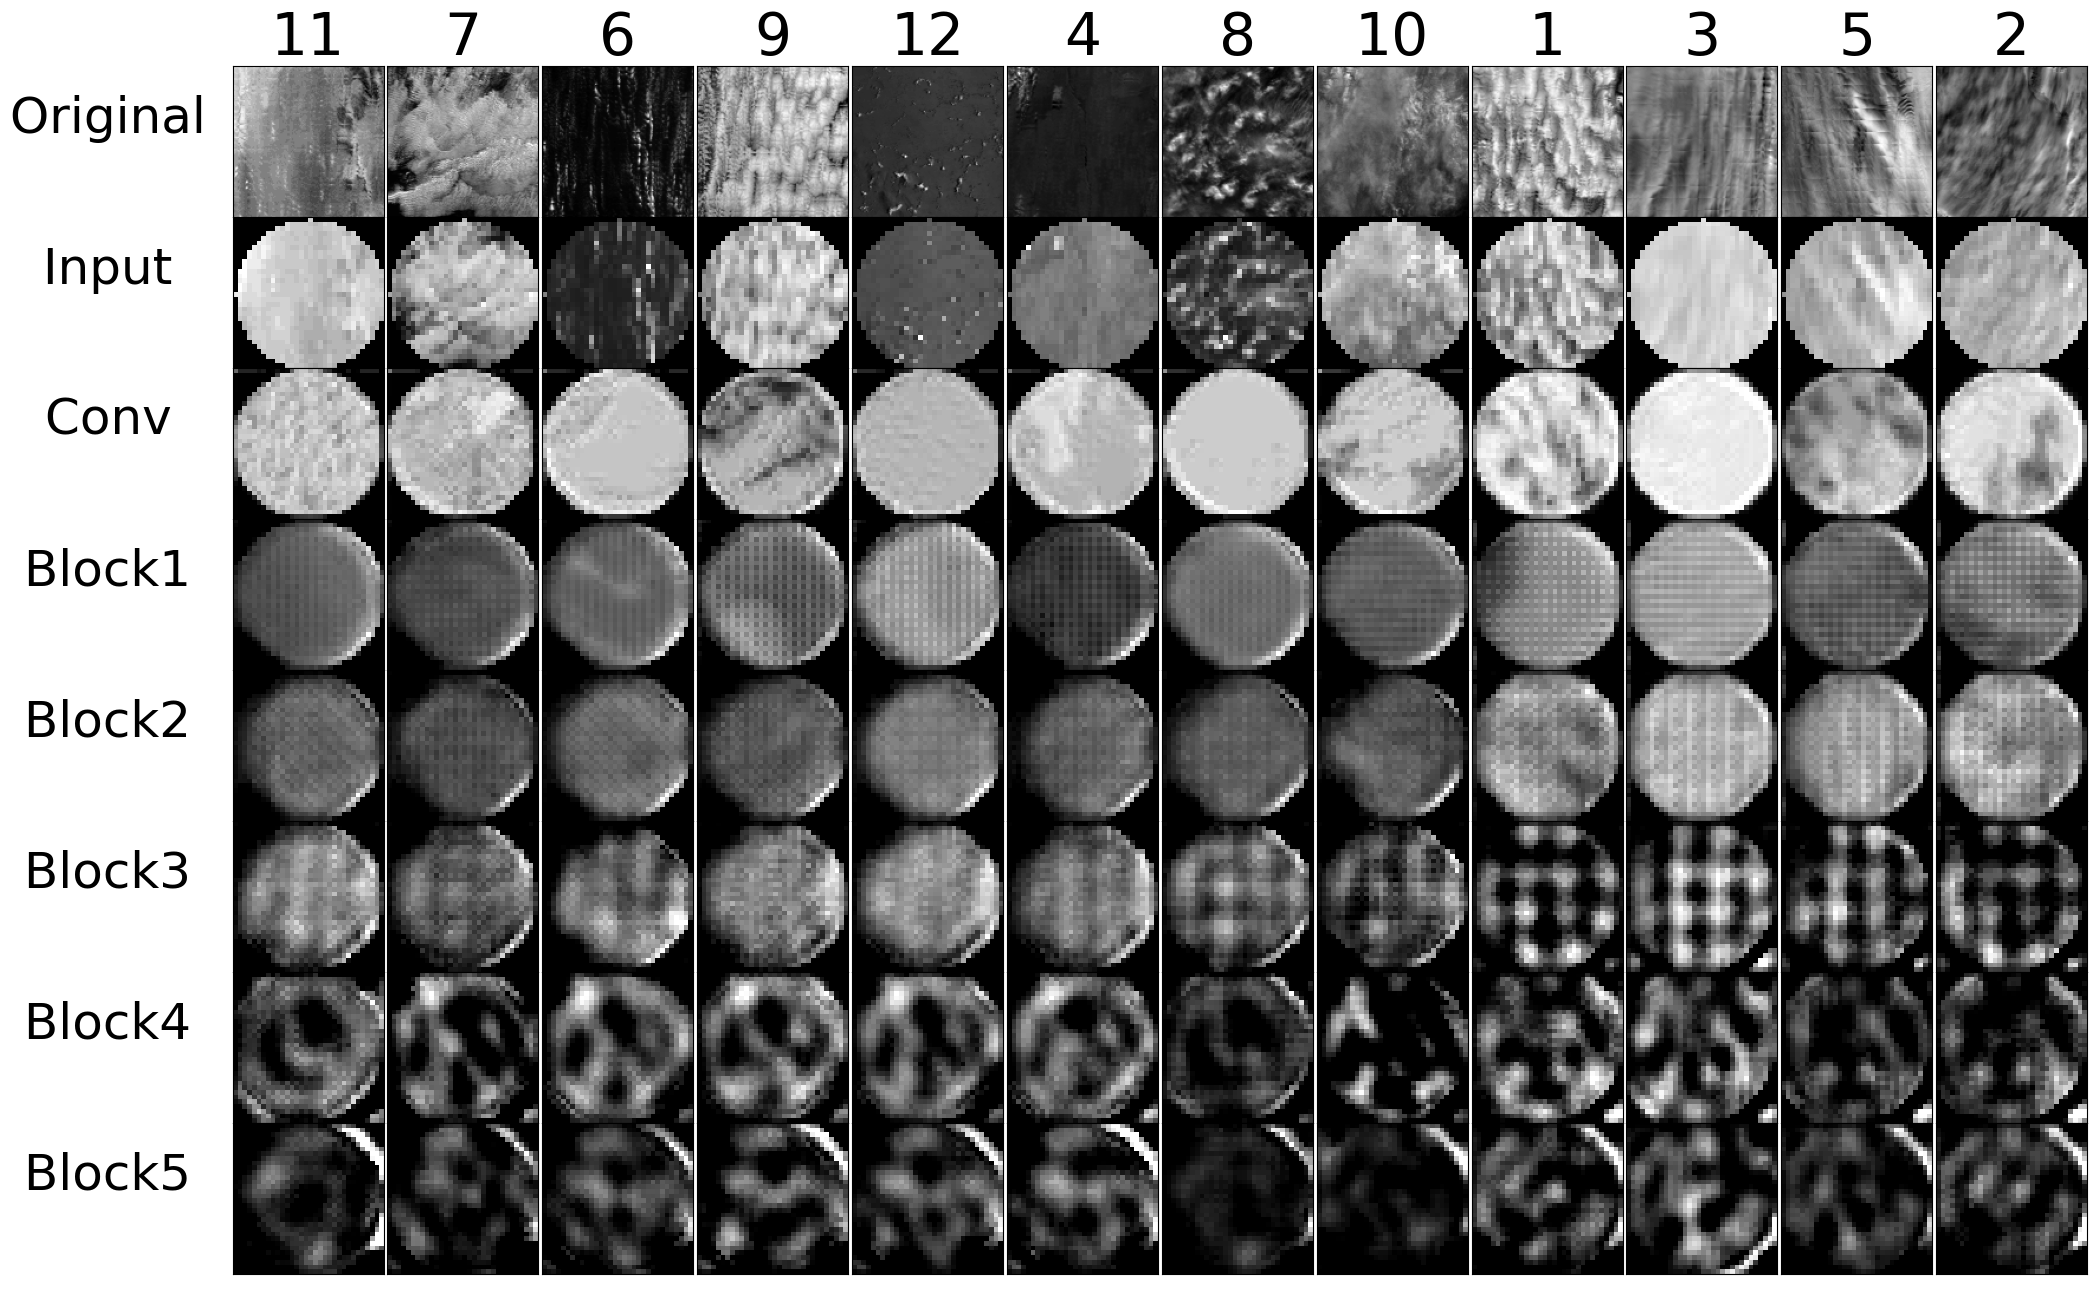

In [32]:
layer_plot_paper3(simages,rsimages, grads_dict,nclusters = 12,ntops = 20,fsize=36,label_fsize=42,
                 alpha=2,ncols=12,nrows=2+len(grads_dict),mycmap = 'binary_r',
                 layer_names=layer_names, ncluster_orders=[10,6,5,8,11,3,7,9,0,2,4,1])

In [27]:
def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x  *= 0.37
    #x *= 0.5

    # clip to [0, 1]
    #x += 0.5
    x = np.clip(x, 0, 1 )
    
    # convert to RGB array
    #x *= 255
    #if K.image_data_format() == 'channels_first':
    #    x = x[:,:,:3].transpose((1, 2, 0))
    #x = np.concatenate([ np.expand_dims(x[:,:,:,i],axis=-1) for i in [0,1,3] ],axis=-1)
    #x = np.clip(x, 0, 255).astype('uint8')
    return x

## Save files

In [35]:
def layer_save_paper3(images,rimages, grads_dict,nclusters = 12,ntops = 20,fsize=30,label_fsize=16,
               mycmap = 'twilight_shifted', alpha=2,ncols=None,nrows=12,layer_names=[],ncluster_orders=[]):
    
    def zscore(data):
        return (data - np.nanmean(data)) / np.nanstd(data)
    for _j, (key, grads) in enumerate(grads_dict.items()):
        grads_np = np.flip(deprocess_image(np.array(grads)),-1)
        print(key, grads_np.shape)
        idx = np.argmax(np.mean(grads_np[j],axis=(0,1)) )
        #cgrads[j,:,:,idx]
    


In [36]:
layer_save_paper3(simages,rsimages, grads_dict,nclusters = 12)

leaky_re_lu (240, 32, 32, 6)
leaky_re_lu_3 (240, 32, 32, 6)
leaky_re_lu_6 (240, 32, 32, 6)
leaky_re_lu_9 (240, 32, 32, 6)
leaky_re_lu_12 (240, 32, 32, 6)
leaky_re_lu_14 (240, 32, 32, 6)
